### Setup

At the time, HF's [evaluation comparison](https://huggingface.co/spaces/evaluate-comparison) space is down. Therefore, below is a couple metrics picked to measure the performances of our different proposed models/structures. 

In [1]:
import os
os.environ['HF_TQDM'] = "false" # disable tqdm output globally, turn off when testing

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from evaluate import load
from typing import List, Union

### BLEU

Bilingual Evaluation Understudy is a metric used to evaluate the quality of machine-generated translations against one or more reference translations. It measures the similarity between the machine-generated translation and the reference translations based on the **n-grams** (contiguous sequences of n words) present in both. BLEU score ranges from 0 to 1, with a higher score indicating a better match between the generated translation and the references. A score of 1 means a perfect match, while a score of 0 means no overlap between the generated and reference translations. [Reference](https://huggingface.co/spaces/evaluate-metric/bleu), and also available [sacrebleu](https://huggingface.co/spaces/evaluate-metric/sacrebleu) and [GLUE](https://huggingface.co/spaces/evaluate-metric/google_bleu)

In [4]:
predictions = ["hello there general kenobi", "foo bar foobar"]
references = [
                ["hello there general kenobi", "hello there !"],
                ["foo bar foobar"]
]
bleu = load("bleu")
results = bleu.compute(predictions=predictions, references=references)
print(results)

{'bleu': 1.0, 'precisions': [1.0, 1.0, 1.0, 1.0], 'brevity_penalty': 1.0, 'length_ratio': 1.1666666666666667, 'translation_length': 7, 'reference_length': 6}


In [5]:
def score_with_bleu(predictions: Union[str, List[str]], references: Union[List[str], List[List[str]]]) -> float: 
    """Generate BLEU score (0 to 1) for generated answers against original answers"""
    # in case string, convert to acceptable format for HF
    if isinstance(predictions, str): predictions = [predictions]
    if isinstance(references, str): references = [[references]]
    # computer BLEU score
    return bleu.compute(references=references, predictions=predictions)['bleu']

In [6]:
# # test with list
# predictions = ["hello there general kenobi", "foo bar foobar"]
# references = [
#                 ["hello there general kenobi"], ["foo bar foobar"] # note: each sublist is a reference
# ]
# score_with_bleu(predictions, references) # should be 1.0

In [7]:
# # test with string
# score_with_bleu("hello there general kenobi", "hello there general kenobi") # should be 1.0

#### Technical details

From the [original BLUE paper](https://aclanthology.org/P02-1040/), we have:

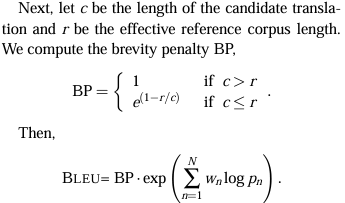

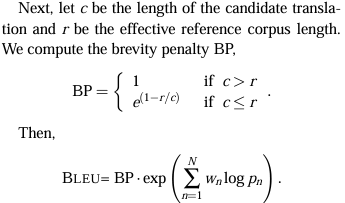

**Limitations and Bias:**

- BLEU compares **overlap** in tokens from the predictions and references, **instead of** comparing **meaning**. This can lead to discrepancies between BLEU scores and human ratings.
- **Shorter predicted translations achieve higher scores** than longer ones, simply due to how the score is calculated. A brevity penalty is introduced to attempt to counteract this.
- BLEU scores are not comparable across different datasets, nor are they comparable across different language.
- BLEU scores can vary greatly depending on which parameters are used to generate the scores, especially when different tokenization and normalization techniques are used. It is therefore not possible to compare BLEU scores generated using different parameters, or when these parameters are unknown.

### ROUGE

ROUGE, or **Recall**-Oriented Understudy for Gisting Evaluation, is a set of metrics and a software package used for evaluating automatic summarization and machine translation software in natural language processing. The metrics compare an automatically produced summary or translation against a reference or a set of references (human-produced) summary or translation. The ROUGE values are in the range of 0 to 1, with higher score as better. [reference](https://huggingface.co/spaces/evaluate-metric/rouge)

In [8]:
rouge = load('rouge')
predictions = ["hello there", "general kenobi"]
references = ["hello there", "general kenobi"] # alternative is a list of lists: e.g., references = [["hello", "there"], ["general kenobi", "general yoda"]]
results = rouge.compute(predictions=predictions,
                        references=references)
results

{'rouge1': 1.0, 'rouge2': 1.0, 'rougeL': 1.0, 'rougeLsum': 1.0}

In [9]:
def score_with_rouge(predictions: List[str], references:Union[List[str], List[List[str]]], rouge_type:str = 'rougeL') -> float: 
    """score with ROGUE, based on the rogue type specified - default to rougeL for longest common subsequence based scoring"""
    # in case string, convert to acceptable format for HF
    if isinstance(predictions, str): predictions = [predictions]
    if isinstance(references, str): references = [references]
    # compute ROGUE score
    return rouge.compute(references=references, predictions=predictions, rouge_types=[rouge_type])[rouge_type]

In [10]:
# predictions = ["hello there", "general kenobi"]
# references = ["hello there", "general kenobi"]
# score_with_rouge(predictions, references) # should be 1.0

In [11]:
# predictions = "hello there"
# references = "hello there"
# score_with_rouge(predictions, references) # should be 1.0

#### Technical details

From [Schluter (2017)](https://aclanthology.org/E17-2007/), we have:

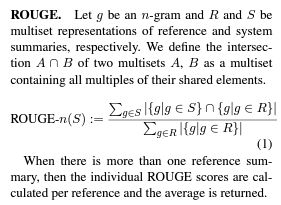

**Limitations and Bias:**

The paper discusses several limitations of the ROUGE metric for evaluating automatic summarization systems. One of the main limitations is that there is no natural upper bound on the quality of summarization systems, which makes it difficult to determine when no further improvement is possible. Additionally, the task of summarization is NP-hard, which means that finding the optimal solution is computationally infeasible. While greedy algorithms have been shown to perform well empirically, there is no guarantee that they will always produce the best possible summary. Finally, the paper notes that ROUGE scores are generally low for short summaries and that there has been no substantial improvement in performance on benchmark datasets in the last decade.

### BERTScore

BERTScore leverages the pre-trained contextual embeddings from BERT and matches words in candidate and reference sentences by **cosine similarity**. It has been shown to correlate with human judgment on sentence-level and system-level evaluation. Moreover, BERTScore computes precision, recall, and F1 measure, which can be useful for evaluating different language generation tasks. [reference](https://huggingface.co/spaces/evaluate-metric/bertscore)

In [12]:
bertscore = load('bertscore')

In [13]:
def score_with_bert(predictions: Union[str, List[str]], references: Union[str, List[str]], lang:str ='en', model_type:str ='distilbert-base-uncased') -> tuple:
    """Output a dictionary of precision, recall and F1 score for BERTScore (all 0.0 to 1.0), default to English and distilbert-base-uncased (268MB)"""
    # in case string, convert to acceptable format for HF
    if isinstance(predictions, str): predictions = [predictions]
    if isinstance(references, str): references = [references]
    # compute BERTScore
    data = bertscore.compute(references=references, predictions=predictions, lang=lang, model_type=model_type)
    results = {key: value for key, value in data.items() if key != 'hashcode'}
    return results['precision'], results['recall'], results['f1']

In [14]:
# predictions = ["hello there", "general kenobi"]
# references = ["hello there", "general kenobi"]
# score_with_bert(predictions, references) # should be 3 lists with 1.0

#### Technical Details

From original [BERTScore paper](https://openreview.net/pdf?id=SkeHuCVFDr) showed that BERTScore correlates well with human judgment on sentence-level and system-level evaluation, but this depends on the model and language pair selected.

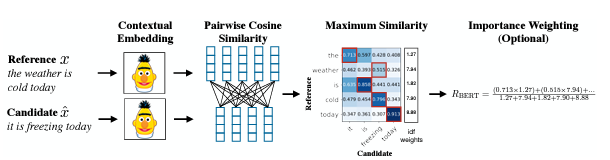

List of BERT models can found [here](https://docs.google.com/spreadsheets/d/1RKOVpselB98Nnh_EOC4A2BYn8_201tmPODpNWu4w7xI/edit#gid=0) - note that calculating the BERTScore metric involves downloading the BERT model that is used to compute the score, which is why here we are using `distilbert-base-uncased` (268MB) as default.

### Others

Not included in our analysis at this stage, 

- and, not intended
    - [Perplexity](https://huggingface.co/spaces/evaluate-metric/perplexity#:~:text=Metric%20Description,text%20it%20was%20trained%20on.): Given a model and an input text sequence, perplexity measures how likely the model is to generate the input text sequence. It is defined as the exponentiated average negative log-likelihood of a sequence, calculated with exponent base `e`. Note that the output value is based heavily on what text the model was trained on. This means that perplexity scores are not comparable between models or datasets.

- but, also up for consideration
    - [BLEURT](https://huggingface.co/spaces/evaluate-metric/bleurt): a learnt evaluation metric for Natural Language Generation. It is built using multiple phases of transfer learning starting from a pretrained BERT model (Devlin et al. 2018) and then employing another pre-training phrase using synthetic data. Finally it is trained on WMT human annotations. You may run BLEURT out-of-the-box or fine-tune it for your specific application (the latter is expected to perform better).
    - [FrugalScore](https://huggingface.co/spaces/evaluate-metric/frugalscore) is a reference-based metric for NLG models evaluation. It is based on a distillation approach that allows to learn a fixed, low cost version of any expensive NLG metric, while retaining most of its original performance. The original [FrugalScore paper](https://arxiv.org/abs/2110.08559) reported that FrugalScore-Tiny retains 97.7/94.7% of the original performance compared to [BertScore](#bertscore) while running 54 times faster and having 84 times less parameters.
    - [MAUVE](https://huggingface.co/spaces/evaluate-metric/mauve) is a measure of the statistical gap between two text distributions, e.g., how far the text written by a model is the distribution of human text, using samples from both distributions.
    - [ChrF and ChrF++](https://huggingface.co/spaces/evaluate-metric/chrf) are two MT evaluation metrics. They both use the F-score statistic for character n-gram matches, and ChrF++ adds word n-grams as well which correlates more strongly with direct assessment.

- but, might be useful for future reference:
    - [code_eval](https://huggingface.co/spaces/evaluate-metric/code_eval): This metric implements the evaluation harness for the HumanEval problem solving dataset described in the paper “Evaluating Large Language Models Trained on Code”.
    - [SARI](https://huggingface.co/spaces/evaluate-metric/sari): a metric used for evaluating automatic text simplification systems. The metric compares the predicted simplified sentences against the reference and the source sentences. It explicitly measures the goodness of words that are added, deleted and kept by the system. Sari = (F1_add + F1_keep + P_del) / 3 where F1_add: n-gram F1 score for add operation F1_keep: n-gram F1 score for keep operation P_del: n-gram precision score for delete operation n = 4, as in the original paper.

### Main

In [15]:
import os
import pandas as pd

folder = os.listdir('data')
files = [file for file in folder if file.endswith('.csv')]
files = [file for file in files if not file.startswith('score_by')] # exclude the scoring files

dataframes = []
for file in files: 
    df = pd.read_csv(os.path.join('data', file))
    dataframes.append(df.reset_index(drop=True)) # reset to avoid NaN when concatenating

df = pd.concat(dataframes, axis=1)
df = df.loc[:,~df.columns.duplicated()] # drop duplicated columns
df.head()

,question,answer,llm_answer,llm_rag_answer,rag_answer
0,How can you migrate an IPv4-only Amazon VPC to...,To migrate an IPv4-only Amazon VPC to support ...,To migrate an IPv4-only Amazon Virtual Private...,To migrate an IPv4-only Amazon VPC to support ...,To migrate an IPv4-only Amazon VPC to support ...
1,How do you view your DHCP option sets in Amazo...,"In Amazon VPC, to view your DHCP option sets, ...","By default, you can view your DHCP option sets...","To view your DHCP option sets in Amazon VPC, y...",To view your DHCP option sets in Amazon VPC an...
2,What is a subnet CIDR reservation in Amazon VP...,A subnet CIDR reservation in Amazon Virtual Pr...,A subnet CIDR reservation in Amazon VPC is a r...,A subnet CIDR reservation is a range of IPv4 o...,A subnet CIDR reservation in Amazon VPC is a r...
3,How does the middlebox routing wizard facilita...,The middlebox routing wizard in Amazon VPC hel...,The middlebox routing wizard facilitates the i...,The middlebox routing wizard facilitates the i...,The middlebox routing wizard in Amazon VPC fac...
4,What are the benefits of monitoring Network Ad...,Monitoring Network Address Usage (NAU) within ...,What are the benefits of monitoring Network Ad...,The benefits of monitoring Network Address Usa...,Monitoring Network Address Usage (NAU) in an A...


In [16]:
# get the prefix of all column names ending with _answer
suffix = '_answer'
model_types = [col[:-len(suffix)] for col in df.columns if col.endswith(suffix)]
model_types

['llm', 'llm_rag', 'rag']

Scoring at the answer level

In [17]:
for mt in model_types: 
    df[f'{mt}_bleu'] = df.apply(lambda row: score_with_bleu(row['answer'], row[f'{mt}_answer']), axis=1)
    df[f'{mt}_rouge'] = df.apply(lambda row: score_with_rouge(row['answer'], row[f'{mt}_answer']), axis=1)
    df[f'{mt}_bert'] = df.apply(lambda row: score_with_bert(row['answer'], row[f'{mt}_answer']), axis=1) # tuple of 3 lists, need to unpack
    df[[f'{mt}_bert_precision', f'{mt}_bert_recall', f'{mt}_bert_f1']] = df[f'{mt}_bert'].apply(lambda x: pd.Series([i[0] for i in x]))
    df.drop(columns=[f'{mt}_bert'], inplace=True)

In [18]:
df.head()

,question,answer,llm_answer,llm_rag_answer,rag_answer,llm_bleu,llm_rouge,llm_bert_precision,llm_bert_recall,llm_bert_f1,llm_rag_bleu,llm_rag_rouge,llm_rag_bert_precision,llm_rag_bert_recall,llm_rag_bert_f1,rag_bleu,rag_rouge,rag_bert_precision,rag_bert_recall,rag_bert_f1
0,How can you migrate an IPv4-only Amazon VPC to...,To migrate an IPv4-only Amazon VPC to support ...,To migrate an IPv4-only Amazon Virtual Private...,To migrate an IPv4-only Amazon VPC to support ...,To migrate an IPv4-only Amazon VPC to support ...,0.116771,0.290598,0.833697,0.864191,0.848670,0.063197,0.242171,0.870316,0.800967,0.834203,0.123887,0.288509,0.884932,0.841144,0.862482
1,How do you view your DHCP option sets in Amazo...,"In Amazon VPC, to view your DHCP option sets, ...","By default, you can view your DHCP option sets...","To view your DHCP option sets in Amazon VPC, y...",To view your DHCP option sets in Amazon VPC an...,0.075391,0.240506,0.854906,0.802528,0.827889,0.023199,0.210101,0.853242,0.805927,0.828910,0.114963,0.257862,0.870800,0.796118,0.831786
2,What is a subnet CIDR reservation in Amazon VP...,A subnet CIDR reservation in Amazon Virtual Pr...,A subnet CIDR reservation in Amazon VPC is a r...,A subnet CIDR reservation is a range of IPv4 o...,A subnet CIDR reservation in Amazon VPC is a r...,0.085042,0.262626,0.794297,0.855345,0.823691,0.048054,0.240175,0.853718,0.765338,0.807116,0.114899,0.386792,0.894457,0.840036,0.866392
3,How does the middlebox routing wizard facilita...,The middlebox routing wizard in Amazon VPC hel...,The middlebox routing wizard facilitates the i...,The middlebox routing wizard facilitates the i...,The middlebox routing wizard in Amazon VPC fac...,0.110100,0.280822,0.839930,0.852829,0.846331,0.021987,0.223108,0.821621,0.793708,0.807423,0.072883,0.255319,0.830224,0.803943,0.816872
4,What are the benefits of monitoring Network Ad...,Monitoring Network Address Usage (NAU) within ...,What are the benefits of monitoring Network Ad...,The benefits of monitoring Network Address Usa...,Monitoring Network Address Usage (NAU) in an A...,0.042988,0.193732,0.830654,0.818970,0.824771,0.010818,0.151329,0.839106,0.776208,0.806432,0.041410,0.242075,0.852904,0.809101,0.830426


In [19]:
# output to csv
df_clean = df.copy()
# update column header: replace all llm with lora
df_clean.columns = df_clean.columns.str.replace('llm', 'lora')
df_clean.to_csv('data/score_by_answer.csv', index=False)

In [23]:
# # get the mean bleu score - not quite the aggregated bleu, but it's the same order and magnitude
# df_clean[[col for col in df_clean.columns if col.endswith('bleu')]].mean(axis=0)

lora_bleu        0.068193
lora_rag_bleu    0.035919
rag_bleu         0.128937
dtype: float64

In [22]:
# # get the mean rouge score - and we can see it's simple mean
# df_clean[[col for col in df_clean.columns if col.endswith('rouge')]].mean(axis=0)

lora_rouge        0.228489
lora_rag_rouge    0.209635
rag_rouge         0.319392
dtype: float64

Scoring at the model level

In [57]:
score_list = []

references = df['answer'].tolist()
references_for_bleu = [[r] for r in references]

for mt in model_types:
    
    predictions = df[f'{mt}_answer'].tolist()
    
    # BLUE and ROUGE scores
    bleu_score = score_with_bleu(predictions, references_for_bleu)
    rouge_score = score_with_rouge(predictions, references)
    
    # BERT scores
    bert_precision_column = f'{mt}_bert_precision'
    bert_precision = df[bert_precision_column].mean()
    bert_recall_column = f'{mt}_bert_recall'
    bert_recall = df[bert_recall_column].mean()
    bert_f1_column = f'{mt}_bert_f1'
    bert_f1 = df[bert_f1_column].mean()
    
    # Append rows to the list as dictionaries
    score_list.append({'model_type': mt, 'metric': 'bleu', 'score': bleu_score})
    score_list.append({'model_type': mt, 'metric': 'rouge', 'score': rouge_score})
    score_list.append({'model_type': mt, 'metric': 'bert_precision', 'score': bert_precision})
    score_list.append({'model_type': mt, 'metric': 'bert_recall', 'score': bert_recall})
    score_list.append({'model_type': mt, 'metric': 'bert_f1', 'score': bert_f1})

# Convert the list of dictionaries into a DataFrame
score_df = pd.DataFrame(score_list)

In [58]:
# sort model type by: rag, lora, rag_lora
score_df = score_df.pivot(index='model_type', columns='metric', values='score')
score_df.index = score_df.index.map({'llm': 'lora', 'llm_rag': 'rag_lora', 'rag': 'rag'})
score_df = score_df.reindex(['rag', 'lora', 'rag_lora'])
score_df

metric,bert_f1,bert_precision,bert_recall,bleu,rouge
model_type,,,,,
rag,0.839283,0.850029,0.829704,0.131537,0.319369
lora,0.815689,0.807801,0.826171,0.097033,0.228654
rag_lora,0.803309,0.834183,0.776578,0.073872,0.209593


In [59]:
# highlight the highest number in each column of score_df
def highlight_max(s):
    '''highlight the maximum in a Series yellow.'''
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

score_df.style.apply(highlight_max, axis=0)

metric,bert_f1,bert_precision,bert_recall,bleu,rouge
model_type,,,,,
rag,0.839283,0.850029,0.829704,0.131537,0.319369
lora,0.815689,0.807801,0.826171,0.097033,0.228654
rag_lora,0.803309,0.834183,0.776578,0.073872,0.209593


In [60]:
# output to csv
score_df.to_csv('data/score_by_model.csv', index=False)